# Subnet 19 Survey - https://tauvision.ai

## First, the Question & Answer section

### Question: In a concise sentence, what does your subnet do? 



### Answer:
Subnet 19 is the definition of Decentralised AI - we incentivise miners to reliabily run Generative AI models, at the largest capacities and quickest speeds possible - whilst giving vaidators the tools to immediately monetise their commodity.

### Question: How are data or tasks being generated (and augmented)?  

### Answer:
Data for tasks are generated in two manners - syntheically, and organically.

Organic generation is data from *real* users. This is data that passes through the servers that the validators spin up and serve requests through.

Synthetic generation is data generated by random processes, and all functions can be seen [here](https://github.com/namoray/vision-workers/blob/main/validator_orchestrator/app/synthetic/synthetic_generation.py).
For text generation, we currently use a Markov-based model. For images, we use a (free, unauthed) service from Picsum to get a random image. We also have a beautiful picture of Post Malone here, which we use for Avatar Synthetics; ![postie](https://raw.githubusercontent.com/namoray/vision/production/validation/synthetic_data/postie.png)

We do this to ensure there is a face, and because he's the GOAT. We also alter this image every single time, to make sure synthetics aren't always the same image [reference](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/synthetic_data/synthetic_generations.py#L55).

If we wanted to make our data more akin to organic requests, for synthetic validators only, we could use miners themselves to generate the data, which we are exploring in a subsequent update.

It's important to note that organic requests are the first class citizen and take priority, with only the minimum number of synthetics needed to test a miner's volume. [Reference](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/uid_manager.py#L150)


### Question: Please explain the Synapse Protocol between miners and validators

### Answer: 

I'm not entirely sure what this question means, but you can see all of our synapses [here](https://github.com/namoray/vision/blob/production/models/synapses.py)

We also slightly rewrote the dendrite protocol to be a bit more efficient for text streaming [here](https://github.com/namoray/vision/blob/production/core/bittensor_overrides/dendrite.py) 

## Note: I'm going to combine the two questions below, as I think they are best answered together 

### Question: What is the expected behavior of a miner? If the current setup deviates from that (e.g., code still under development), explain how the miners currently respond
### Question: What does the validation mechanism look like? Detail the validation process from validators sending synapses via dendrite to setting weights on the subtensor, referencing specific lines of code for a step-by-step guide and model that were being used in the process.


### Answer:

First, let me grace you with a big diagram

![Subnet flow](https://f004.backblazeb2.com/file/tauvision/subnet_flow.png)

References:
- [1](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/models/synapses.py#L13)
- [2](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/uid_manager.py#L239)
- [3](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/uid_manager.py#L139)
- [4](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/uid_manager.py#L196) (note we have a dedicated method for organics here)
- [5](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/scoring/scoring_utils.py#L22)
- [6](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/scoring/scoring_utils.py#L8)
- [7](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/scoring/main.py#L68) (Uses the GPU server here: https://github.com/namoray/vision-workers)
- [8](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/core/constants.py#L4)
- [9](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/models.py#L39)
- [10](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/weight_setting/main.py#L24)
- [11](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/weight_setting/calculations.py#L89)
- [12](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/weight_setting/calculations.py#L86)
- [13](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/weight_setting/calculations.py#L123)
- [14](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/weight_setting/main.py#L73)


I think the above diagram and code describe it pretty well. A few important points:
- Miners are expected to run as many of the tasks they like, defined [here](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/core/__init__.py#L5)
- Tasks are independent of each other - your scores are a weighted linear combination of your scores for each task, with weightings defined [here](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/core_validator.py#L113)
- Validators and miners run separate GPU and proxy servers - so their proxy servers can scale and handle requests independently of the actual AI inference. Repo for the GPU stuff is [here](https://github.com/namoray/vision-workers)
- Miners all receive different requests, and are scored on completely independent requests to each other - we do not send out 1 request to every miner
- Capacities are announced proportional to GPU seconds. Tokens for LLMs, steps for image generation models. This is so we have the desirable property of rewarding directly proportional to FLOPS & therefore cost to the miner

### Calculation of quality scores & speed scoring factors for each task
Each task has a different method of calculating Quality scores (i.e. did you run the correct model) and Speed scores (i.e. how fast did you run the correct model).

#### Quality scores
Quality scores for LLM's work are as follows:
- Miners send back each token, along with its probability of being selected
- (x10 times in a loop) Validators pick a random token in your response and calculate the ground truth probabilities by running the same model  [reference](https://github.com/namoray/vision-workers/blob/de0dd9e4e293e6820092aad6de42d77a701c95ab/validator_orchestrator/app/checking/checking_functions.py#L268)
- They compare that and get a distance. We then require your log probability distance to be below a small threshold. This is extremely robust, and by far the most accurate way of verifying LLMs. It's amazing because:
    - We can check requests by only inferring from 10 tokens, allowing us to check huge responses quickly
    - We can let you use any temperature you want. Temperature only affects probabilities, so the validator can just use the same temperature when checking, and we're safe
  
For Images:
- Try to reproduce the exact same image, with the same seed, and compare using clip similarity and our custom reward model [1](https://github.com/namoray/vision-workers/blob/de0dd9e4e293e6820092aad6de42d77a701c95ab/validator_orchestrator/app/checking/checking_functions.py#L167) [2](https://github.com/namoray/vision-workers/blob/de0dd9e4e293e6820092aad6de42d77a701c95ab/validator_orchestrator/app/checking/checking_functions.py#L199)
- We built a custom reward model to reduce the chance of false positives and negatives. [1](https://github.com/namoray/vision-workers/blob/de0dd9e4e293e6820092aad6de42d77a701c95ab/validator_orchestrator/app/checking/checking_functions.py#L206)

#### Speed scoring factors
We define the speed scoring for each task [here](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/core/tasks.py#L92)
Speed scores are calculated [here](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/proxy/work_and_speed_functions.py#L16)

Summary:
- We reward below and above the mean differently, but to achieve the same goal, which is to encourage fast speeds and discourage slow speeds non-linearly
- There is a potential improvement here - I would rather dynamically get the mean from all participants, rather than define it myself, so I don't need to continually update it when the miners keep improving faster than I can push updates :D

### Summary:
Miners run known (currently...) AI models. They are tightly validated to check they are running the correct model (with some leeway for optimizations), and rewarded directly for their speed.

### Question: How is the user served in the network?

### Answer
The end user is a priority, and all validators come built-in with their own (optional) [proxy server](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/validation/proxy/api_server/asgi.py);
It handles:
- Adding API keys
- Billing
- Rate limiting
- Automatic documentation (/docs)
- All synapses and tasks, with queries organically scored

The only thing a validator needs to do is opt-in [by specifying a port](https://github.com/namoray/vision/blob/4aaec3b3cd468643e7de706c533a713ed3110c8b/docs/validating.md#managing-organic-access)

The end user is so well prioritized, that validators have built countless apps on subnet 19. Here is a list of 5, but there are loads.
- MODE [Mixture of Decentralised Experts](https://beta.corcel.io/chat); Note some features here are on Testnet for SN19, for example, the coding model, but all the main inference happens through Llama3 and the image models from sn19, and we'll be adding the new models soon. **I've sent details of how to access this to PigeonSyndrome, or you can create an account and apply for beta access**
- [Image studio](https://app.corcel.io/image-studio)
- [Avatar](https://app.corcel.io/image-studio/avatar/app). You may have seen lots of Bittensor discord profile pictures generated from this
- [Tao bot](https://interact.tao.bot/vision)
- [Tauvision FAQ bot](https://tauvision.ai/release-bot)
- [Creator bid](https://www.creator.bid/)

![Mode](https://f004.backblazeb2.com/file/tauvision/mode.png)

### Question: Any API available? 

### Answer; Yes!!

Every single validator has their API if they want it, we are completely decentralized. The Taostats & Corcel validator uses us heavily, and has a [public API](https://api.corcel.io/docs)

### Question: Any known exploitation and solutions?


### Answer: Nope.

We don't currently know of any explotations on subnet19, and have faced 0 miners exploiting the subnet in the ~8 months we've been running. There was a bug in the scoring found by Isabel in January, which was patched before any exploits took place (though, admittedly, we had some miscommunication initially and I misunderstood what she meant so I didn't patch it instantly - my fault completely. Small blip though and we still caught it in time!)

### Question: Roadmap:


### Answer: (Please keep to yourselves if possible - only some of this is ready to be public)

We haven't published a public roadmap, as we've just finished a big round of releases. But we move so fast, that we're already halfway through the next big round :D Let me give a nice overview:
- Complete rewrite to separate the different services in the code and move to a more distrubted-service-based architecture. This has immense benefits:
    - The first subnet to be truly horizontally scalable - we need it to support high requests/s
    - A 'signing node', which is an isolated container containing the private keys - the only container which needs it. Massively increasing security, and will be open-sourced in Python & Rust for all the community to use
    - All dockerised, extremely easy to deploy anywhere with docker-compose, and eventually, K8 if you want to
- A lot more tools and emphasis on the competition factor in the subnet; see below for a screenshot of the pages in progress
- Once we finish rewriting the code (estimate for prod, 3 weeks), massively raise the caps for volumes, further encouraging competition
- Add Llama3.1 8B and, probably, Llama3.1 70B. ETA is Monday
- Finish the rewrite of our validation code for LLMs, so we can run huge models on validators, completely decentralized. Llama3.1 405B will come to subnet 19 and be validated by everyone. We will have the best decentralized open-sourced LLMs in the world. ETA 4 weeks for 405B
- (Early in dev, can't say too much yet) Dynamic task to let miners run any model they like on SN19 - subject to a high score. I am confident we will have the best LLM in the world on subnet 19. Better than Claude, OpenAI GPT-4o, anything - validators will have the most single valuable commodity to sell, and they will always have it. ETA 8 weeks. Also extremely nice interfaces to interact with this model and prove it the best, but I'm told it is too early to share screenshots yet :D

![Leaderboards](https://f004.backblazeb2.com/file/tauvision/leaderboards.png)

![Leaderboards 2](https://f004.backblazeb2.com/file/tauvision/leaderboards-2.png)

### Question: Extra points
(Be careful what you wish for 😈)

Extra points:
### - [Refactor diagram](https://excalidraw.com/#json=A27Ys7YtzHTq-fw7PwHu_,p7j1liAsmmnwDkrxjM9Zkw)
### - Why SN19 deserves emissions
I believe there are lots of compelling cases as to why SN19 not only deserves emissions in general but also why I think SN19 is exponentially the best subnet. I'll (try to) keep it short and sweet with bullet points:
- Our miners deserve the most emissions. They run expensive servers to produce the most valuable digital commodity, there are no wasted hash rates here. They also are in constant competition to be the best - more emissions help us draw better competition. This will be extremely relevant as we try to run Llama 3.1 405B, and also in the next phase when we *will* get the best LLM in the world on the subnet. To get the best, we need to encourage the best.
- The most decentralized. 100% of everything in our subnet is open-sourced and decentralized. Validators don't need any subnet-owner API, miners don't need me. Validators all have their own API servers and can provide access to whomever they want. They have all the tools, and there is nothing special about anyone. All models are open source and run by the miners, not a single centralized API is needed. This is the endgame for Bittensor, Decentralised AI. We are already there.
- Well-designed and implemented incentive mechanism. We have a near-perfect curve, with near-perfect vtrust, and miners are constantly improving (and incentivized well to do so). The validators will end up with the most valuable digital commodity, and we have cut 0 corners
- Fast iterations; we're already on vision 4.1, and will soon be on 5.0. We are always improving, and never stagnant. We ship quickly but iterate even quicker, and development is very active
- Most community-driven; every update gets either [a full change proposal](https://tauvision.ai/docs/proposal), or an [in-depth discussion](https://discord.com/channels/799672011265015819/1186691482749505627/1263918732598837288). In fact, most of discord is filled with discussion about how we should keep improving, rather than problems with our subnet. We're already on the path that DTAO intends to carve, and have the right balance between healthy discussion and continuing to ship code.
- Most valuable digital commodity; the validators have proved that the commodity on SN19 is not only the easiest to access and supply, but the most valuable and useful. It has been an absolute priority since day 1. Revenue generation and real-world use are not an afterthought for us, but a priority on day 1. We have the most traffic out of any bittensor built product.
- Backed by [research from Cambridge University Alumni](https://tauvision.ai/whitepapers/dsis); we've engaged the top Math graduates from a top university to help us build the foundation of our scoring mechanism. DSIS ensures all validators get proportional access to their digital commodity. Validator value is fundamental, and we did not skip over this
- Ease of setup, and validator support; we have always supported validators with 15-7 support (I only ask for some sleep :D) since the dawn of the subnet. I truly believe we have provided the highest level of support, and I think all validators would attest to this if asked. Furthermore, we have easy-to-use config files for quick restarts, no end of tooling to help validators setup GPUs, auto-updates on all components, dockerized AI models, self-heal to prevent downtime, and top vtrust, etc etc
- We improve the most. We know we still have lots of potential and work to do, of course. I think we've demonstrated we are on it, and use any funding we get to help build a large team with plenty of resources to lead the charge to Decentralised AI


### - Storyboard in progress for informative video about the subnet: [Storyboard](storyboard.png)
### - Even more info if you're still reading
- Below I'll go through an example of the scoring calculations, to give you a feel of the competition we've inspired

Here we demonstrate how the scoring mechanism works, and how the miners are incentivised strongly to compete eachother.
It also demonstrates how the subnet is split into distinct tasks, and you get an all-in-one combined score

**NOTE: The data is fresh, pulled at ~ Wednesday 24th July 0:00 UTC - from the T&C validator**

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json

sns.set_style("whitegrid")
sns.set_palette("husl")



def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)


average_speed_scoring_factors = load_json("average_speed_scoring_factors.json")
average_quality_scores = load_json("average_quality_scores.json")
combined_quality_scores = load_json("combined_quality_scores.json")
normalised_scores = load_json("normalised_scores.json")


**Please Note**: All the below stats where calculated using the code [here](https://github.com/namoray/vision/blob/main/validation/weight_setting/calculations.py)

All our data is made open every day on tauvision, at [https://data.tauvision.ai/2024-07-24_uid_records.csv](https://data.tauvision.ai/2024-07-24_uid_records.csv) or [https://data.tauvision.ai/2024-07-24_rewards.csv](https://data.tauvision.ai/2024-07-24_rewards.csv)

This lets miners know exactly how to improve, and you can replace 2024-07-24 with different dates, to see how the subnet is evolving

Miners are rewarded for their speed in completing tasks, and get a 'speed scoring factor'. This is a value 0 < x < 1.6 (1.6 is a parameter), which follows a distribution
similar to below

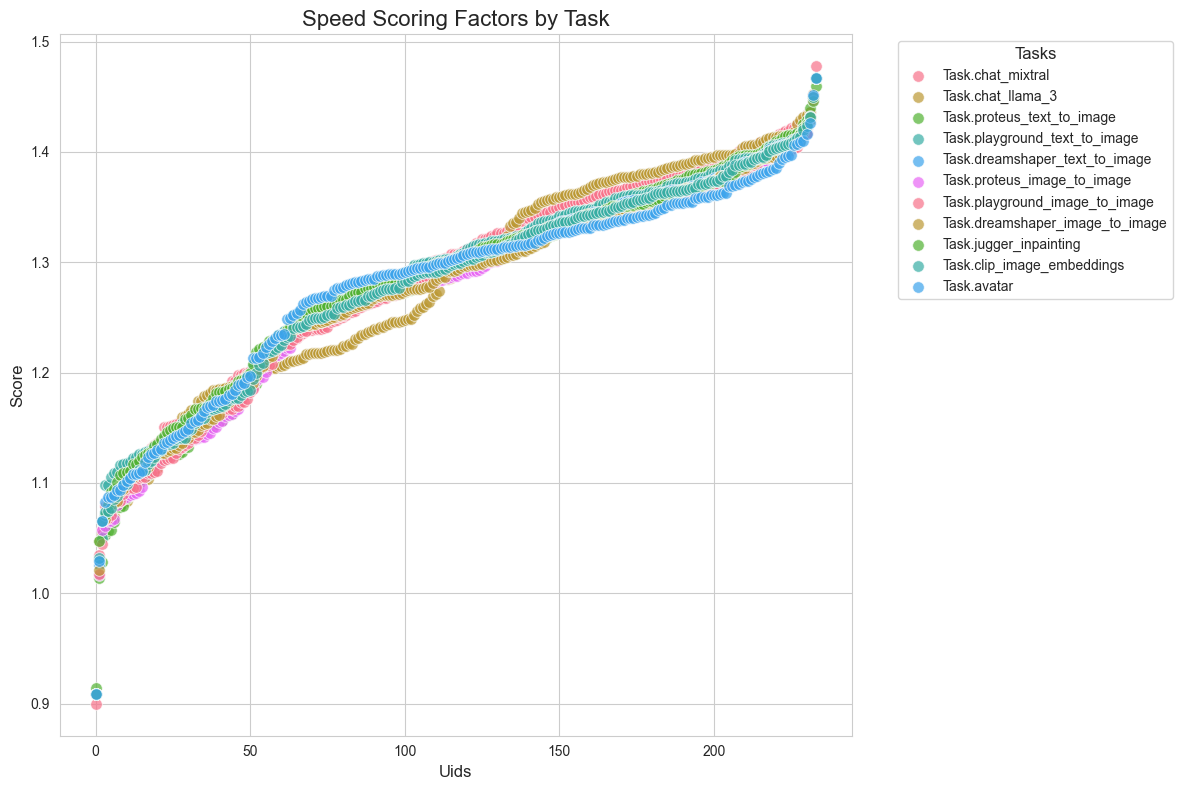

In [18]:
plt.figure(figsize=(12, 8))

for task, scores in average_speed_scoring_factors.items():
    values = list(scores.values())
    sns.scatterplot(x=range(len(values)), y=sorted(values), label=task, s=70, alpha=0.7)

plt.title("Speed Scoring Factors by Task", fontsize=16)
plt.xlabel("Uids", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Tasks", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


They then also get a 'Quality score'. A value < 1, which shows how close they are to the model we expect them to run.
There are some false negatives, and some optimisations miners made to sometimes get more negatives, hence some values are < 1

The validation mechanism is very tight though, so any values >> 1 means the correct model is being run - all the values here are examples
of that

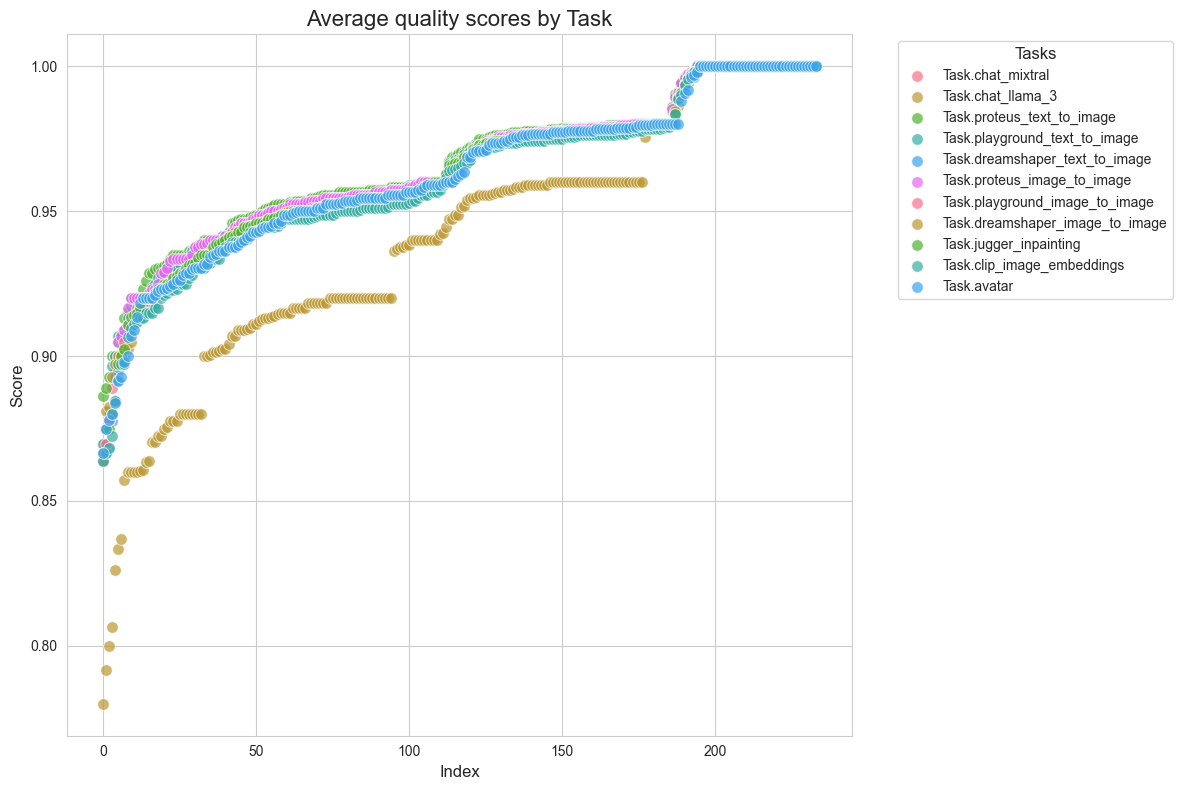

In [20]:
plt.figure(figsize=(12, 8))

for task, scores in average_quality_scores.items():
    values = list(scores.values())
    sns.scatterplot(x=range(len(values)), y=sorted(values), label=task, s=70, alpha=0.7)

plt.title("Average quality scores by Task", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Tasks", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Combine speed and quality scores to get the combined quality scores

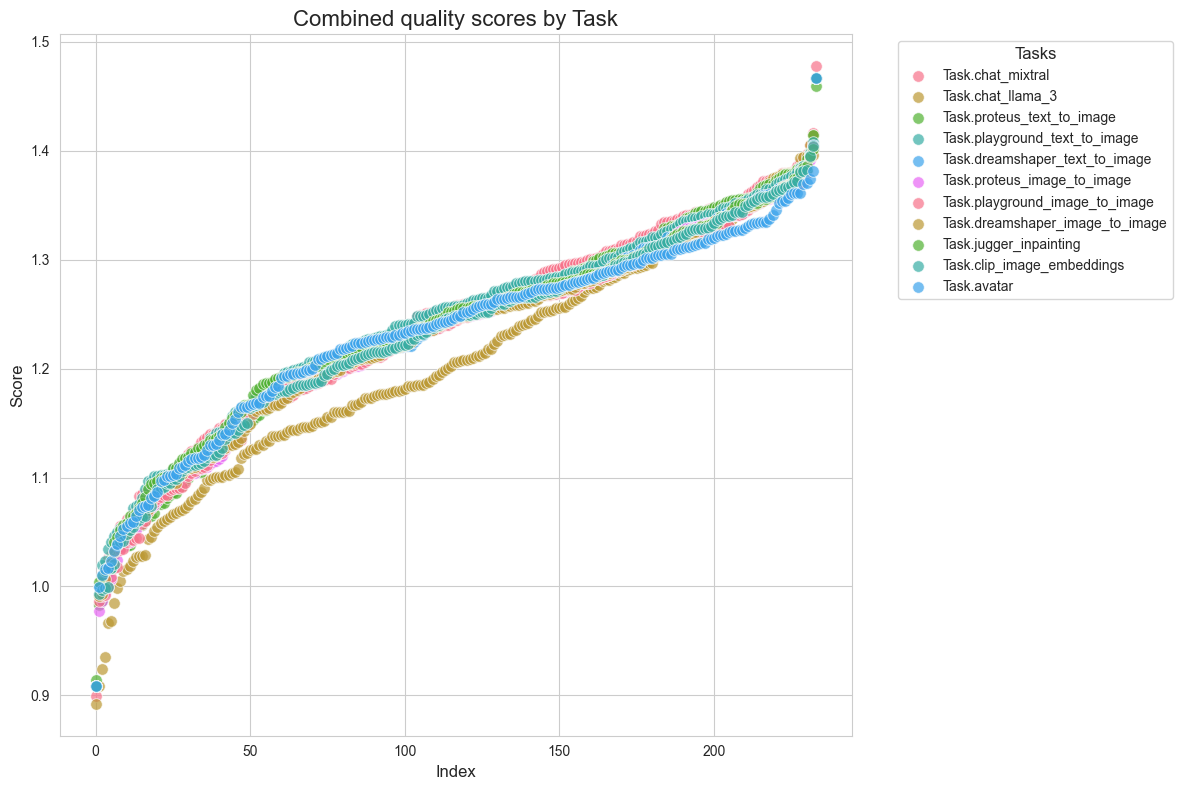

In [22]:
plt.figure(figsize=(12, 8))

for task, scores in combined_quality_scores.items():
    values = list(scores.values())
    sns.scatterplot(x=range(len(values)), y=sorted(values), label=task, s=70, alpha=0.7)

plt.title("Combined quality scores by Task", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Tasks", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Normalised scores, after non linear scaling is applied. A miners total score (incentive) will be a weighted linear combinated of each of these tasks

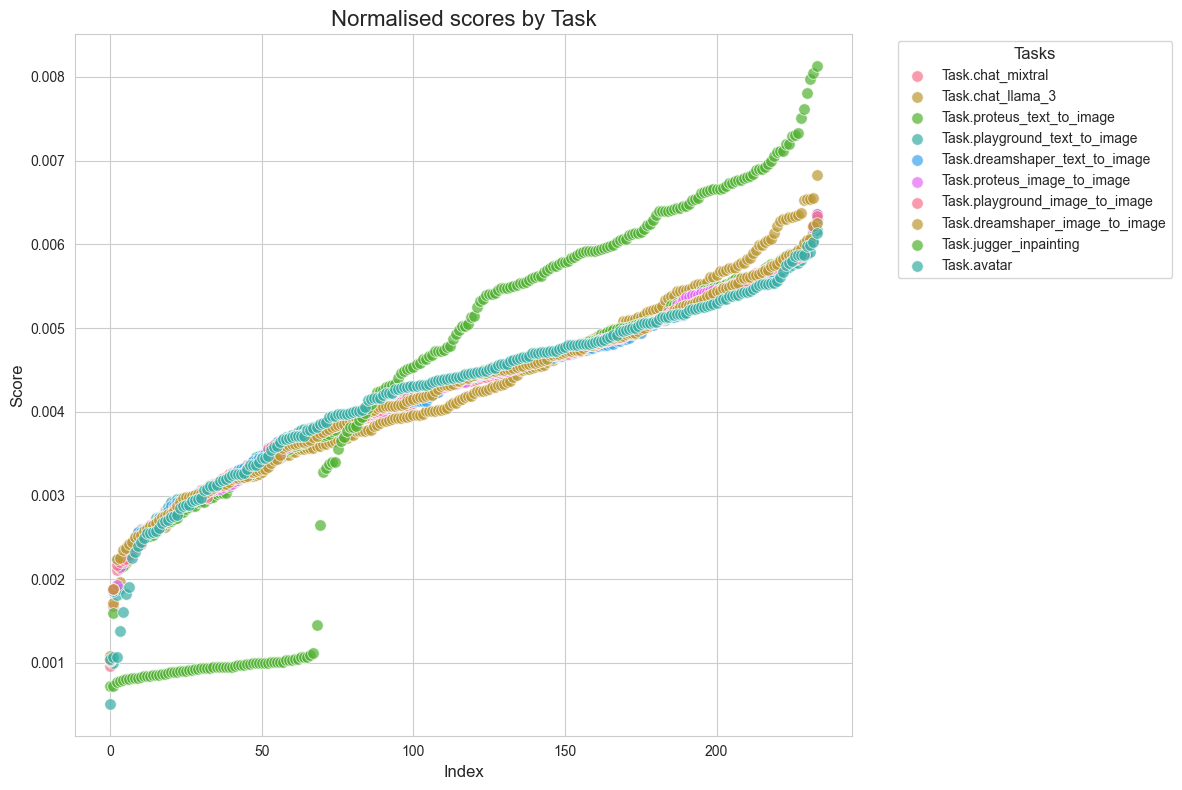

In [24]:
plt.figure(figsize=(12, 8))

for task, scores in normalised_scores.items():
    values = list(scores.values())
    sns.scatterplot(x=range(len(values)), y=sorted(values), label=task, s=70, alpha=0.7)

plt.title("Normalised scores by Task", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Tasks", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Here are the tasks combined, to reveal the final incentives!

/var/folders/71/h6wg7h657cj9hn4_8nqmqk1w0000gn/T/ipykernel_37617/2068331567.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Tasks", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')


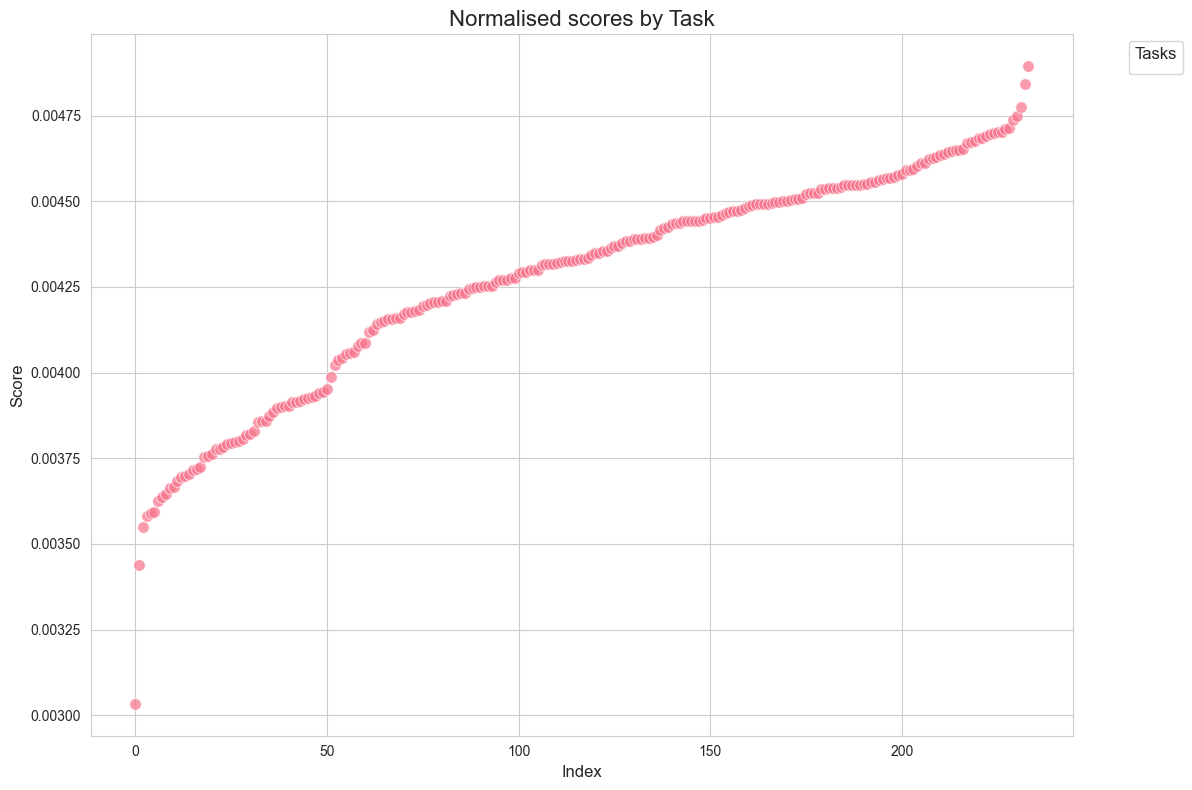

In [26]:
# Changeable at any time
task_weights = {
    'Task.chat_mixtral': 0.1,
    'Task.chat_llama_3': 0.1,
    'Task.proteus_text_to_image': 0.2,
    'Task.playground_text_to_image': 0.1,
    'Task.dreamshaper_text_to_image': 0.05,
    'Task.proteus_image_to_image': 0.1,
    'Task.playground_image_to_image': 0.05,
    'Task.dreamshaper_image_to_image': 0.05,
    'Task.jugger_inpainting': 0.05,
    'Task.clip_image_embeddings': 0.0,
    'Task.avatar': 0.2
}

combined_hotkey_scores = {}

for task, scores in average_speed_scoring_factors.items():
    task_weight = task_weights.get(task, 0)  # Default to 0 if task not in weights
    for hotkey, score in scores.items():
        if hotkey not in combined_hotkey_scores:
            combined_hotkey_scores[hotkey] = 0
        combined_hotkey_scores[hotkey] += score * task_weight

total_score = sum(combined_hotkey_scores.values())
normalized_combined_scores = {k: v / total_score for k, v in combined_hotkey_scores.items()}

sorted_combined_scores = dict(sorted(normalized_combined_scores.items()))
y = list(sorted_combined_scores.values())

plt.figure(figsize=(12, 8))


sns.scatterplot(x=range(len(y)), y=sorted(y),  s=70, alpha=0.7)

plt.title("Normalised scores by Task", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Tasks", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## When combined across all validators (This was data for just one), we get a curve like this:

![Distribution](https://f004.backblazeb2.com/file/tauvision/Distribution.png)


Top miners have over double the incentive of the bottom miners, but we also keep top vtrust amongst all validators - showing we are not just forcing a curve (the validators with vtrust <0.9 are running an old version, update was deployed monday)


![Vtrusts](https://f004.backblazeb2.com/file/tauvision/Vtrusts.png)

We can also take this further, but we need to be careful. 

We do not, however, want to end up in a 'winner takes all' situation. We need a sufficient amount of miners to be in profit and incentivised to run stable services,
so the validators have nice stable services to build on top of. We also don't want to completely *closed* off competition for all except one entity.

I think right now we have a good balance and a great curve.
Once we can truly lift the cap on volumes, then we would see a natural shift of the curve again.

Overall, we are very nearly there. We have a great solid setup for validation here, and it's all about tuning and tweaking some parameters to get the exact outcomes we want, without forcing a curve or making sacrifices.